#  Competencia 2 | Feature Engineering en SQL
Data mining en economía y finanzas

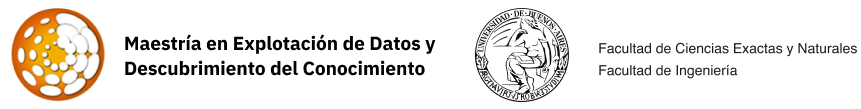

[Víctor A. Bettachini](mailto:bettachini@gmail.com)

## Importación de bibliotecas  

In [3]:
try:
    import duckdb
except:
    ! pip install duckdb
    ! pip install jupysql
    ! pip install duckdb-engine
    import duckdb
# Restart kernel after install

In [4]:
# Load jupySQL extension
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

Quiero crear una archivo de base de datos en archivo, no en memoria.

In [5]:
# Instead of in memory, this will create a file in the dataset directory  

# # Start a DuckDB in-memory database
# %sql duckdb:///:default:
 
%sql duckdb:///../../normanbuck/datasets/zweite.db 

## Importación de CSV con datos y clase ternaria hecha con script en Julia 

In [6]:
%%time
%%sql
create or replace table engineered as
select
    *
from read_csv_auto('../../normanbuck/datasets/competencia_02.csv.gz')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 3min 11s, sys: 7.79 s, total: 3min 18s
Wall time: 1min 9s


,Success


## Atributos redundantes

### Tarjetas de crédito

Tanto `Visa_mconsumospesos` y `Visa_mconsumototal` como `Master_mconsumospesos` y `Master_mconsumototal` son equivalentes.

In [7]:
%%sql
alter table engineered
drop Master_mconsumototal

,Success


In [8]:
%%sql
alter table engineered
drop Visa_mconsumototal

,Success


### Autoservicio y ATM

Son iguales la suma de `catm_trx` y `catm_trx_other` que `cextraccion_autoservicio`.

In [9]:
%%sql
alter table engineered
drop cextraccion_autoservicio

,Success


## Nuevos atributos

### Saldos negativos

In [10]:
%%sql
alter table engineered
add column mcuentas_saldo_neg tinyint

,Success


In [11]:
%%sql
update engineered
set mcuentas_saldo_neg = case when mcuentas_saldo < 0 then 1 else 0 end

,Success


In [12]:
%%sql
alter table engineered
add column mcuentas_otras_neg int1

,Success


In [13]:
%%sql
update engineered
set mcuentas_otras_neg = case when
  (mcuenta_corriente + mcuenta_corriente_adicional + mcaja_ahorro + mcaja_ahorro_adicional + mcaja_ahorro_dolares) < 0 then 1 else 0 end

,Success


#### Autoservicio y ATM

Indica mayor uso ATM de otro banco.

In [14]:
%%sql
alter table engineered
add column catm_mayor_oth tinyint

,Success


In [15]:
%%sql
update engineered
set catm_mayor_oth = case when
  (catm_trx_other - catm_trx) < 0 then 1 else 0 end

,Success


## Coalesce tarjetas de credito

In [16]:
%%sql
alter table engineered
add column mtarjeta_consumo int8

,Success


In [17]:
%%sql
update engineered
set mtarjeta_consumo = mtarjeta_master_consumo + mtarjeta_visa_consumo

,Success


In [18]:
%%sql
alter table engineered
drop mtarjeta_master_consumo 

,Success


In [19]:
%%sql
alter table engineered
drop mtarjeta_visa_consumo 

,Success


### Proxy actividad sumando el valor absoluto de todos los monetarios (no tarjetas)

In [20]:
%%sql
alter table engineered
add column actividad long

,Success


In [21]:
%%sql
update engineered
set actividad = abs(matm_other) + abs(matm) +
    abs(mcheques_emitidos_rechazados) + abs(mcheques_depositados_rechazados) +
    abs(mcheques_emitidos) + abs(mcheques_depositados) +
    abs(mextraccion_autoservicio) + abs(mautoservicio) +
    abs(mtransferencias_emitidas) + abs(mtransferencias_recibidas) +
    abs(mforex_sell) + abs(mforex_buy) +
    abs(mpagomiscuentas) + abs(mpagodeservicios) +
    abs(mttarjeta_master_debitos_automaticos) + abs(mttarjeta_visa_debitos_automaticos) +
    abs(mcuenta_debitos_automaticos) + abs(mpayroll2) + abs(mpayroll) +
    abs(minversion2) + abs(minversion1_pesos) + abs(minversion1_dolares) +
    abs(mplazo_fijo_pesos) + abs(mplazo_fijo_dolares) +
    abs(mprestamos_hipotecarios) + abs(mprestamos_prendarios) + abs(mprestamos_personales) +
    abs(mtarjeta_consumo) + 
    abs(mcaja_ahorro_dolares) + abs(mcaja_ahorro_adicional) + abs(mcaja_ahorro) +
    abs(mcuenta_corriente) + abs(mcuenta_corriente_adicional)

,Success


## Monetarias lags normalizados durante un semestre

## Crea la vista

In [ ]:
%%sql
CREATE OR REPLACE TABLE engineered AS
select 
  *
  , min(mcuenta_corriente_adicional) over semestre as mcuenta_corriente_adicional_min6, max(mcuenta_corriente_adicional) over semestre as mcuenta_corriente_adicional_max6, avg(mcuenta_corriente_adicional) over semestre as mcuenta_corriente_adicional_avg6, LAG(mcuenta_corriente_adicional, 1) OVER semestre AS mcuenta_corriente_adicional_d1, LAG(mcuenta_corriente_adicional, 2) OVER semestre AS mcuenta_corriente_adicional_l2, LAG(mcuenta_corriente_adicional, 3) OVER semestre AS mcuenta_corriente_adicional_l3, LAG(mcuenta_corriente_adicional, 4) OVER semestre AS mcuenta_corriente_adicional_l4, LAG(mcuenta_corriente_adicional, 5) OVER semestre AS mcuenta_corriente_adicional_l5, LAG(mcuenta_corriente_adicional, 6) OVER semestre AS mcuenta_corriente_adicional_l6, mcuenta_corriente_adicional - LAG(mcuenta_corriente_adicional, 1) OVER semestre AS mcuenta_corriente_adicional_d1, mcuenta_corriente_adicional - LAG(mcuenta_corriente_adicional, 2) OVER semestre AS mcuenta_corriente_adicional_d2, mcuenta_corriente_adicional - LAG(mcuenta_corriente_adicional, 3) OVER semestre AS mcuenta_corriente_adicional_d3, mcuenta_corriente_adicional - LAG(mcuenta_corriente_adicional, 4) OVER semestre AS mcuenta_corriente_adicional_d4, mcuenta_corriente_adicional - LAG(mcuenta_corriente_adicional, 5) OVER semestre AS mcuenta_corriente_adicional_d5, mcuenta_corriente_adicional - LAG(mcuenta_corriente_adicional, 6) OVER semestre AS mcuenta_corriente_adicional_d6, mcuenta_corriente_adicional/ AVG(mcuenta_corriente_adicional) OVER semestre AS mcuenta_corriente_adicional_dn6
  , min(mcuenta_corriente) over semestre as mcuenta_corriente_min6, max(mcuenta_corriente) over semestre as mcuenta_corriente_max6, avg(mcuenta_corriente) over semestre as mcuenta_corriente_avg6, LAG(mcuenta_corriente, 1) OVER semestre AS mcuenta_corriente_d1, LAG(mcuenta_corriente, 2) OVER semestre AS mcuenta_corriente_l2, LAG(mcuenta_corriente, 3) OVER semestre AS mcuenta_corriente_l3, LAG(mcuenta_corriente, 4) OVER semestre AS mcuenta_corriente_l4, LAG(mcuenta_corriente, 5) OVER semestre AS mcuenta_corriente_l5, LAG(mcuenta_corriente, 6) OVER semestre AS mcuenta_corriente_l6, mcuenta_corriente - LAG(mcuenta_corriente, 1) OVER semestre AS mcuenta_corriente_d1, mcuenta_corriente - LAG(mcuenta_corriente, 2) OVER semestre AS mcuenta_corriente_d2, mcuenta_corriente - LAG(mcuenta_corriente, 3) OVER semestre AS mcuenta_corriente_d3, mcuenta_corriente - LAG(mcuenta_corriente, 4) OVER semestre AS mcuenta_corriente_d4, mcuenta_corriente - LAG(mcuenta_corriente, 5) OVER semestre AS mcuenta_corriente_d5, mcuenta_corriente - LAG(mcuenta_corriente, 6) OVER semestre AS mcuenta_corriente_d6, mcuenta_corriente/ AVG(mcuenta_corriente) OVER semestre AS mcuenta_corriente_dn6
  , min(mcaja_ahorro) over semestre as mcaja_ahorro_min6, max(mcaja_ahorro) over semestre as mcaja_ahorro_max6, avg(mcaja_ahorro) over semestre as mcaja_ahorro_avg6, LAG(mcaja_ahorro, 1) OVER semestre AS mcaja_ahorro_d1, LAG(mcaja_ahorro, 2) OVER semestre AS mcaja_ahorro_l2, LAG(mcaja_ahorro, 3) OVER semestre AS mcaja_ahorro_l3, LAG(mcaja_ahorro, 4) OVER semestre AS mcaja_ahorro_l4, LAG(mcaja_ahorro, 5) OVER semestre AS mcaja_ahorro_l5, LAG(mcaja_ahorro, 6) OVER semestre AS mcaja_ahorro_l6, mcaja_ahorro - LAG(mcaja_ahorro, 1) OVER semestre AS mcaja_ahorro_d1, mcaja_ahorro - LAG(mcaja_ahorro, 2) OVER semestre AS mcaja_ahorro_d2, mcaja_ahorro - LAG(mcaja_ahorro, 3) OVER semestre AS mcaja_ahorro_d3, mcaja_ahorro - LAG(mcaja_ahorro, 4) OVER semestre AS mcaja_ahorro_d4, mcaja_ahorro - LAG(mcaja_ahorro, 5) OVER semestre AS mcaja_ahorro_d5, mcaja_ahorro - LAG(mcaja_ahorro, 6) OVER semestre AS mcaja_ahorro_d6, mcaja_ahorro/ AVG(mcaja_ahorro) OVER semestre AS mcaja_ahorro_dn6
  , min(mcaja_ahorro_adicional) over semestre as mcaja_ahorro_adicional_min6, max(mcaja_ahorro_adicional) over semestre as mcaja_ahorro_adicional_max6, avg(mcaja_ahorro_adicional) over semestre as mcaja_ahorro_adicional_avg6, LAG(mcaja_ahorro_adicional, 1) OVER semestre AS mcaja_ahorro_adicional_d1, LAG(mcaja_ahorro_adicional, 2) OVER semestre AS mcaja_ahorro_adicional_l2, LAG(mcaja_ahorro_adicional, 3) OVER semestre AS mcaja_ahorro_adicional_l3, LAG(mcaja_ahorro_adicional, 4) OVER semestre AS mcaja_ahorro_adicional_l4, LAG(mcaja_ahorro_adicional, 5) OVER semestre AS mcaja_ahorro_adicional_l5, LAG(mcaja_ahorro_adicional, 6) OVER semestre AS mcaja_ahorro_adicional_l6, mcaja_ahorro_adicional - LAG(mcaja_ahorro_adicional, 1) OVER semestre AS mcaja_ahorro_adicional_d1, mcaja_ahorro_adicional - LAG(mcaja_ahorro_adicional, 2) OVER semestre AS mcaja_ahorro_adicional_d2, mcaja_ahorro_adicional - LAG(mcaja_ahorro_adicional, 3) OVER semestre AS mcaja_ahorro_adicional_d3, mcaja_ahorro_adicional - LAG(mcaja_ahorro_adicional, 4) OVER semestre AS mcaja_ahorro_adicional_d4, mcaja_ahorro_adicional - LAG(mcaja_ahorro_adicional, 5) OVER semestre AS mcaja_ahorro_adicional_d5, mcaja_ahorro_adicional - LAG(mcaja_ahorro_adicional, 6) OVER semestre AS mcaja_ahorro_adicional_d6, mcaja_ahorro_adicional/ AVG(mcaja_ahorro_adicional) OVER semestre AS mcaja_ahorro_adicional_dn6
  , min(mcaja_ahorro_dolares) over semestre as mcaja_ahorro_dolares_min6, max(mcaja_ahorro_dolares) over semestre as mcaja_ahorro_dolares_max6, avg(mcaja_ahorro_dolares) over semestre as mcaja_ahorro_dolares_avg6, LAG(mcaja_ahorro_dolares, 1) OVER semestre AS mcaja_ahorro_dolares_d1, LAG(mcaja_ahorro_dolares, 2) OVER semestre AS mcaja_ahorro_dolares_l2, LAG(mcaja_ahorro_dolares, 3) OVER semestre AS mcaja_ahorro_dolares_l3, LAG(mcaja_ahorro_dolares, 4) OVER semestre AS mcaja_ahorro_dolares_l4, LAG(mcaja_ahorro_dolares, 5) OVER semestre AS mcaja_ahorro_dolares_l5, LAG(mcaja_ahorro_dolares, 6) OVER semestre AS mcaja_ahorro_dolares_l6, mcaja_ahorro_dolares - LAG(mcaja_ahorro_dolares, 1) OVER semestre AS mcaja_ahorro_dolares_d1, mcaja_ahorro_dolares - LAG(mcaja_ahorro_dolares, 2) OVER semestre AS mcaja_ahorro_dolares_d2, mcaja_ahorro_dolares - LAG(mcaja_ahorro_dolares, 3) OVER semestre AS mcaja_ahorro_dolares_d3, mcaja_ahorro_dolares - LAG(mcaja_ahorro_dolares, 4) OVER semestre AS mcaja_ahorro_dolares_d4, mcaja_ahorro_dolares - LAG(mcaja_ahorro_dolares, 5) OVER semestre AS mcaja_ahorro_dolares_d5, mcaja_ahorro_dolares - LAG(mcaja_ahorro_dolares, 6) OVER semestre AS mcaja_ahorro_dolares_d6, mcaja_ahorro_dolares/ AVG(mcaja_ahorro_dolares) OVER semestre AS mcaja_ahorro_dolares_dn6
  , min(mcuentas_saldo) over semestre as mcuentas_saldo_min6, max(mcuentas_saldo) over semestre as mcuentas_saldo_max6, avg(mcuentas_saldo) over semestre as mcuentas_saldo_avg6, LAG(mcuentas_saldo, 1) OVER semestre AS mcuentas_saldo_d1, LAG(mcuentas_saldo, 2) OVER semestre AS mcuentas_saldo_l2, LAG(mcuentas_saldo, 3) OVER semestre AS mcuentas_saldo_l3, LAG(mcuentas_saldo, 4) OVER semestre AS mcuentas_saldo_l4, LAG(mcuentas_saldo, 5) OVER semestre AS mcuentas_saldo_l5, LAG(mcuentas_saldo, 6) OVER semestre AS mcuentas_saldo_l6, mcuentas_saldo - LAG(mcuentas_saldo, 1) OVER semestre AS mcuentas_saldo_d1, mcuentas_saldo - LAG(mcuentas_saldo, 2) OVER semestre AS mcuentas_saldo_d2, mcuentas_saldo - LAG(mcuentas_saldo, 3) OVER semestre AS mcuentas_saldo_d3, mcuentas_saldo - LAG(mcuentas_saldo, 4) OVER semestre AS mcuentas_saldo_d4, mcuentas_saldo - LAG(mcuentas_saldo, 5) OVER semestre AS mcuentas_saldo_d5, mcuentas_saldo - LAG(mcuentas_saldo, 6) OVER semestre AS mcuentas_saldo_d6, mcuentas_saldo/ AVG(mcuentas_saldo) OVER semestre AS mcuentas_saldo_dn6
  , min(actividad) over semestre as actividad_min6, max(actividad) over semestre as actividad_max6, avg(actividad) over semestre as actividad_avg6, LAG(actividad, 1) OVER semestre AS actividad_d1, LAG(actividad, 2) OVER semestre AS actividad_l2, LAG(actividad, 3) OVER semestre AS actividad_l3, LAG(actividad, 4) OVER semestre AS actividad_l4, LAG(actividad, 5) OVER semestre AS actividad_l5, LAG(actividad, 6) OVER semestre AS actividad_l6, actividad - LAG(actividad, 1) OVER semestre AS actividad_d1, actividad - LAG(actividad, 2) OVER semestre AS actividad_d2, actividad - LAG(actividad, 3) OVER semestre AS actividad_d3, actividad - LAG(actividad, 4) OVER semestre AS actividad_d4, actividad - LAG(actividad, 5) OVER semestre AS actividad_d5, actividad - LAG(actividad, 6) OVER semestre AS actividad_d6, actividad/ AVG(actividad) OVER semestre AS actividad_dn6
  , min(mpayroll) over semestre as mpayroll_min6, max(mpayroll) over semestre as mpayroll_max6, avg(mpayroll) over semestre as mpayroll_avg6, LAG(mpayroll, 1) OVER semestre AS mpayroll_d1, LAG(mpayroll, 2) OVER semestre AS mpayroll_l2, LAG(mpayroll, 3) OVER semestre AS mpayroll_l3, LAG(mpayroll, 4) OVER semestre AS mpayroll_l4, LAG(mpayroll, 5) OVER semestre AS mpayroll_l5, LAG(mpayroll, 6) OVER semestre AS mpayroll_l6, mpayroll - LAG(mpayroll, 1) OVER semestre AS mpayroll_d1, mpayroll - LAG(mpayroll, 2) OVER semestre AS mpayroll_d2, mpayroll - LAG(mpayroll, 3) OVER semestre AS mpayroll_d3, mpayroll - LAG(mpayroll, 4) OVER semestre AS mpayroll_d4, mpayroll - LAG(mpayroll, 5) OVER semestre AS mpayroll_d5, mpayroll - LAG(mpayroll, 6) OVER semestre AS mpayroll_d6, mpayroll/ AVG(mpayroll) OVER semestre AS mpayroll_dn6
  , min(mautoservicio) over semestre as mautoservicio_min6, max(mautoservicio) over semestre as mautoservicio_max6, avg(mautoservicio) over semestre as mautoservicio_avg6, LAG(mautoservicio, 1) OVER semestre AS mautoservicio_d1, LAG(mautoservicio, 2) OVER semestre AS mautoservicio_l2, LAG(mautoservicio, 3) OVER semestre AS mautoservicio_l3, LAG(mautoservicio, 4) OVER semestre AS mautoservicio_l4, LAG(mautoservicio, 5) OVER semestre AS mautoservicio_l5, LAG(mautoservicio, 6) OVER semestre AS mautoservicio_l6, mautoservicio - LAG(mautoservicio, 1) OVER semestre AS mautoservicio_d1, mautoservicio - LAG(mautoservicio, 2) OVER semestre AS mautoservicio_d2, mautoservicio - LAG(mautoservicio, 3) OVER semestre AS mautoservicio_d3, mautoservicio - LAG(mautoservicio, 4) OVER semestre AS mautoservicio_d4, mautoservicio - LAG(mautoservicio, 5) OVER semestre AS mautoservicio_d5, mautoservicio - LAG(mautoservicio, 6) OVER semestre AS mautoservicio_d6, mautoservicio/ AVG(mautoservicio) OVER semestre AS mautoservicio_dn6
  , min(mtarjeta_consumo) over semestre as mtarjeta_consumo_min6, max(mtarjeta_consumo) over semestre as mtarjeta_consumo_max6, avg(mtarjeta_consumo) over semestre as mtarjeta_consumo_avg6, LAG(mtarjeta_consumo, 1) OVER semestre AS mtarjeta_consumo_d1, LAG(mtarjeta_consumo, 2) OVER semestre AS mtarjeta_consumo_l2, LAG(mtarjeta_consumo, 3) OVER semestre AS mtarjeta_consumo_l3, LAG(mtarjeta_consumo, 4) OVER semestre AS mtarjeta_consumo_l4, LAG(mtarjeta_consumo, 5) OVER semestre AS mtarjeta_consumo_l5, LAG(mtarjeta_consumo, 6) OVER semestre AS mtarjeta_consumo_l6, mtarjeta_consumo - LAG(mtarjeta_consumo, 1) OVER semestre AS mtarjeta_consumo_d1, mtarjeta_consumo - LAG(mtarjeta_consumo, 2) OVER semestre AS mtarjeta_consumo_d2, mtarjeta_consumo - LAG(mtarjeta_consumo, 3) OVER semestre AS mtarjeta_consumo_d3, mtarjeta_consumo - LAG(mtarjeta_consumo, 4) OVER semestre AS mtarjeta_consumo_d4, mtarjeta_consumo - LAG(mtarjeta_consumo, 5) OVER semestre AS mtarjeta_consumo_d5, mtarjeta_consumo - LAG(mtarjeta_consumo, 6) OVER semestre AS mtarjeta_consumo_d6, mtarjeta_consumo/ AVG(mtarjeta_consumo) OVER semestre AS mtarjeta_consumo_dn6
  , min(mdebitos_automaticos) over semestre as mdebitos_automaticos_min6, max(mdebitos_automaticos) over semestre as mdebitos_automaticos_max6, avg(mdebitos_automaticos) over semestre as mdebitos_automaticos_avg6, LAG(mdebitos_automaticos, 1) OVER semestre AS mdebitos_automaticos_d1, LAG(mdebitos_automaticos, 2) OVER semestre AS mdebitos_automaticos_l2, LAG(mdebitos_automaticos, 3) OVER semestre AS mdebitos_automaticos_l3, LAG(mdebitos_automaticos, 4) OVER semestre AS mdebitos_automaticos_l4, LAG(mdebitos_automaticos, 5) OVER semestre AS mdebitos_automaticos_l5, LAG(mdebitos_automaticos, 6) OVER semestre AS mdebitos_automaticos_l6, mdebitos_automaticos - LAG(mdebitos_automaticos, 1) OVER semestre AS mdebitos_automaticos_d1, mdebitos_automaticos - LAG(mdebitos_automaticos, 2) OVER semestre AS mdebitos_automaticos_d2, mdebitos_automaticos - LAG(mdebitos_automaticos, 3) OVER semestre AS mdebitos_automaticos_d3, mdebitos_automaticos - LAG(mdebitos_automaticos, 4) OVER semestre AS mdebitos_automaticos_d4, mdebitos_automaticos - LAG(mdebitos_automaticos, 5) OVER semestre AS mdebitos_automaticos_d5, mdebitos_automaticos - LAG(mdebitos_automaticos, 6) OVER semestre AS mdebitos_automaticos_d6, mdebitos_automaticos/ AVG(mdebitos_automaticos) OVER semestre AS mdebitos_automaticos_dn6
  , min(cpayroll_trx) over semestre as cpayroll_trx_min6, max(cpayroll_trx) over semestre as cpayroll_trx_max6, avg(cpayroll_trx) over semestre as cpayroll_trx_avg6, LAG(cpayroll_trx, 1) OVER semestre AS cpayroll_trx_d1, LAG(cpayroll_trx, 2) OVER semestre AS cpayroll_trx_l2, LAG(cpayroll_trx, 3) OVER semestre AS cpayroll_trx_l3, LAG(cpayroll_trx, 4) OVER semestre AS cpayroll_trx_l4, LAG(cpayroll_trx, 5) OVER semestre AS cpayroll_trx_l5, LAG(cpayroll_trx, 6) OVER semestre AS cpayroll_trx_l6, cpayroll_trx - LAG(cpayroll_trx, 1) OVER semestre AS cpayroll_trx_d1, cpayroll_trx - LAG(cpayroll_trx, 2) OVER semestre AS cpayroll_trx_d2, cpayroll_trx - LAG(cpayroll_trx, 3) OVER semestre AS cpayroll_trx_d3, cpayroll_trx - LAG(cpayroll_trx, 4) OVER semestre AS cpayroll_trx_d4, cpayroll_trx - LAG(cpayroll_trx, 5) OVER semestre AS cpayroll_trx_d5, cpayroll_trx - LAG(cpayroll_trx, 6) OVER semestre AS cpayroll_trx_d6, cpayroll_trx/ AVG(cpayroll_trx) OVER semestre AS cpayroll_trx_dn6
  , min(cdebitos_automaticos) over semestre as cdebitos_automaticos_min6, max(cdebitos_automaticos) over semestre as cdebitos_automaticos_max6, avg(cdebitos_automaticos) over semestre as cdebitos_automaticos_avg6, LAG(cdebitos_automaticos, 1) OVER semestre AS cdebitos_automaticos_d1, LAG(cdebitos_automaticos, 2) OVER semestre AS cdebitos_automaticos_l2, LAG(cdebitos_automaticos, 3) OVER semestre AS cdebitos_automaticos_l3, LAG(cdebitos_automaticos, 4) OVER semestre AS cdebitos_automaticos_l4, LAG(cdebitos_automaticos, 5) OVER semestre AS cdebitos_automaticos_l5, LAG(cdebitos_automaticos, 6) OVER semestre AS cdebitos_automaticos_l6, cdebitos_automaticos - LAG(cdebitos_automaticos, 1) OVER semestre AS cdebitos_automaticos_d1, cdebitos_automaticos - LAG(cdebitos_automaticos, 2) OVER semestre AS cdebitos_automaticos_d2, cdebitos_automaticos - LAG(cdebitos_automaticos, 3) OVER semestre AS cdebitos_automaticos_d3, cdebitos_automaticos - LAG(cdebitos_automaticos, 4) OVER semestre AS cdebitos_automaticos_d4, cdebitos_automaticos - LAG(cdebitos_automaticos, 5) OVER semestre AS cdebitos_automaticos_d5, cdebitos_automaticos - LAG(cdebitos_automaticos, 6) OVER semestre AS cdebitos_automaticos_d6, cdebitos_automaticos/ AVG(cdebitos_automaticos) OVER semestre AS cdebitos_automaticos_dn6
  , min(catm_trx_other) over semestre as catm_trx_other_min6, max(catm_trx_other) over semestre as catm_trx_other_max6, avg(catm_trx_other) over semestre as catm_trx_other_avg6, LAG(catm_trx_other, 1) OVER semestre AS catm_trx_other_d1, LAG(catm_trx_other, 2) OVER semestre AS catm_trx_other_l2, LAG(catm_trx_other, 3) OVER semestre AS catm_trx_other_l3, LAG(catm_trx_other, 4) OVER semestre AS catm_trx_other_l4, LAG(catm_trx_other, 5) OVER semestre AS catm_trx_other_l5, LAG(catm_trx_other, 6) OVER semestre AS catm_trx_other_l6, catm_trx_other - LAG(catm_trx_other, 1) OVER semestre AS catm_trx_other_d1, catm_trx_other - LAG(catm_trx_other, 2) OVER semestre AS catm_trx_other_d2, catm_trx_other - LAG(catm_trx_other, 3) OVER semestre AS catm_trx_other_d3, catm_trx_other - LAG(catm_trx_other, 4) OVER semestre AS catm_trx_other_d4, catm_trx_other - LAG(catm_trx_other, 5) OVER semestre AS catm_trx_other_d5, catm_trx_other - LAG(catm_trx_other, 6) OVER semestre AS catm_trx_other_d6, catm_trx_other/ AVG(catm_trx_other) OVER semestre AS catm_trx_other_dn6
  , min(catm_trx) over semestre as catm_trx_min6, max(catm_trx) over semestre as catm_trx_max6, avg(catm_trx) over semestre as catm_trx_avg6, LAG(catm_trx, 1) OVER semestre AS catm_trx_d1, LAG(catm_trx, 2) OVER semestre AS catm_trx_l2, LAG(catm_trx, 3) OVER semestre AS catm_trx_l3, LAG(catm_trx, 4) OVER semestre AS catm_trx_l4, LAG(catm_trx, 5) OVER semestre AS catm_trx_l5, LAG(catm_trx, 6) OVER semestre AS catm_trx_l6, catm_trx - LAG(catm_trx, 1) OVER semestre AS catm_trx_d1, catm_trx - LAG(catm_trx, 2) OVER semestre AS catm_trx_d2, catm_trx - LAG(catm_trx, 3) OVER semestre AS catm_trx_d3, catm_trx - LAG(catm_trx, 4) OVER semestre AS catm_trx_d4, catm_trx - LAG(catm_trx, 5) OVER semestre AS catm_trx_d5, catm_trx - LAG(catm_trx, 6) OVER semestre AS catm_trx_d6, catm_trx/ AVG(catm_trx) OVER semestre AS catm_trx_dn6
  , min(cforex) over semestre as cforex_min6, max(cforex) over semestre as cforex_max6, avg(cforex) over semestre as cforex_avg6, LAG(cforex, 1) OVER semestre AS cforex_d1, LAG(cforex, 2) OVER semestre AS cforex_l2, LAG(cforex, 3) OVER semestre AS cforex_l3, LAG(cforex, 4) OVER semestre AS cforex_l4, LAG(cforex, 5) OVER semestre AS cforex_l5, LAG(cforex, 6) OVER semestre AS cforex_l6, cforex - LAG(cforex, 1) OVER semestre AS cforex_d1, cforex - LAG(cforex, 2) OVER semestre AS cforex_d2, cforex - LAG(cforex, 3) OVER semestre AS cforex_d3, cforex - LAG(cforex, 4) OVER semestre AS cforex_d4, cforex - LAG(cforex, 5) OVER semestre AS cforex_d5, cforex - LAG(cforex, 6) OVER semestre AS cforex_d6, cforex/ AVG(cforex) OVER semestre AS cforex_dn6
  , min(cprestamos_personales) over semestre as cprestamos_personales_min6, max(cprestamos_personales) over semestre as cprestamos_personales_max6, avg(cprestamos_personales) over semestre as cprestamos_personales_avg6, LAG(cprestamos_personales, 1) OVER semestre AS cprestamos_personales_d1, LAG(cprestamos_personales, 2) OVER semestre AS cprestamos_personales_l2, LAG(cprestamos_personales, 3) OVER semestre AS cprestamos_personales_l3, LAG(cprestamos_personales, 4) OVER semestre AS cprestamos_personales_l4, LAG(cprestamos_personales, 5) OVER semestre AS cprestamos_personales_l5, LAG(cprestamos_personales, 6) OVER semestre AS cprestamos_personales_l6, cprestamos_personales - LAG(cprestamos_personales, 1) OVER semestre AS cprestamos_personales_d1, cprestamos_personales - LAG(cprestamos_personales, 2) OVER semestre AS cprestamos_personales_d2, cprestamos_personales - LAG(cprestamos_personales, 3) OVER semestre AS cprestamos_personales_d3, cprestamos_personales - LAG(cprestamos_personales, 4) OVER semestre AS cprestamos_personales_d4, cprestamos_personales - LAG(cprestamos_personales, 5) OVER semestre AS cprestamos_personales_d5, cprestamos_personales - LAG(cprestamos_personales, 6) OVER semestre AS cprestamos_personales_d6, cprestamos_personales/ AVG(cprestamos_personales) OVER semestre AS cprestamos_personales_dn6
  , min(cprestamos_prendarios) over semestre as cprestamos_prendarios_min6, max(cprestamos_prendarios) over semestre as cprestamos_prendarios_max6, avg(cprestamos_prendarios) over semestre as cprestamos_prendarios_avg6, LAG(cprestamos_prendarios, 1) OVER semestre AS cprestamos_prendarios_d1, LAG(cprestamos_prendarios, 2) OVER semestre AS cprestamos_prendarios_l2, LAG(cprestamos_prendarios, 3) OVER semestre AS cprestamos_prendarios_l3, LAG(cprestamos_prendarios, 4) OVER semestre AS cprestamos_prendarios_l4, LAG(cprestamos_prendarios, 5) OVER semestre AS cprestamos_prendarios_l5, LAG(cprestamos_prendarios, 6) OVER semestre AS cprestamos_prendarios_l6, cprestamos_prendarios - LAG(cprestamos_prendarios, 1) OVER semestre AS cprestamos_prendarios_d1, cprestamos_prendarios - LAG(cprestamos_prendarios, 2) OVER semestre AS cprestamos_prendarios_d2, cprestamos_prendarios - LAG(cprestamos_prendarios, 3) OVER semestre AS cprestamos_prendarios_d3, cprestamos_prendarios - LAG(cprestamos_prendarios, 4) OVER semestre AS cprestamos_prendarios_d4, cprestamos_prendarios - LAG(cprestamos_prendarios, 5) OVER semestre AS cprestamos_prendarios_d5, cprestamos_prendarios - LAG(cprestamos_prendarios, 6) OVER semestre AS cprestamos_prendarios_d6, cprestamos_prendarios/ AVG(cprestamos_prendarios) OVER semestre AS cprestamos_prendarios_dn6
  , min(cprestamos_hipotecarios) over semestre as cprestamos_hipotecarios_min6, max(cprestamos_hipotecarios) over semestre as cprestamos_hipotecarios_max6, avg(cprestamos_hipotecarios) over semestre as cprestamos_hipotecarios_avg6, LAG(cprestamos_hipotecarios, 1) OVER semestre AS cprestamos_hipotecarios_d1, LAG(cprestamos_hipotecarios, 2) OVER semestre AS cprestamos_hipotecarios_l2, LAG(cprestamos_hipotecarios, 3) OVER semestre AS cprestamos_hipotecarios_l3, LAG(cprestamos_hipotecarios, 4) OVER semestre AS cprestamos_hipotecarios_l4, LAG(cprestamos_hipotecarios, 5) OVER semestre AS cprestamos_hipotecarios_l5, LAG(cprestamos_hipotecarios, 6) OVER semestre AS cprestamos_hipotecarios_l6, cprestamos_hipotecarios - LAG(cprestamos_hipotecarios, 1) OVER semestre AS cprestamos_hipotecarios_d1, cprestamos_hipotecarios - LAG(cprestamos_hipotecarios, 2) OVER semestre AS cprestamos_hipotecarios_d2, cprestamos_hipotecarios - LAG(cprestamos_hipotecarios, 3) OVER semestre AS cprestamos_hipotecarios_d3, cprestamos_hipotecarios - LAG(cprestamos_hipotecarios, 4) OVER semestre AS cprestamos_hipotecarios_d4, cprestamos_hipotecarios - LAG(cprestamos_hipotecarios, 5) OVER semestre AS cprestamos_hipotecarios_d5, cprestamos_hipotecarios - LAG(cprestamos_hipotecarios, 6) OVER semestre AS cprestamos_hipotecarios_d6, cprestamos_hipotecarios/ AVG(cprestamos_hipotecarios) OVER semestre AS cprestamos_hipotecarios_dn6
  , min(cinversion1) over semestre as cinversion1_min6, max(cinversion1) over semestre as cinversion1_max6, avg(cinversion1) over semestre as cinversion1_avg6, LAG(cinversion1, 1) OVER semestre AS cinversion1_d1, LAG(cinversion1, 2) OVER semestre AS cinversion1_l2, LAG(cinversion1, 3) OVER semestre AS cinversion1_l3, LAG(cinversion1, 4) OVER semestre AS cinversion1_l4, LAG(cinversion1, 5) OVER semestre AS cinversion1_l5, LAG(cinversion1, 6) OVER semestre AS cinversion1_l6, cinversion1 - LAG(cinversion1, 1) OVER semestre AS cinversion1_d1, cinversion1 - LAG(cinversion1, 2) OVER semestre AS cinversion1_d2, cinversion1 - LAG(cinversion1, 3) OVER semestre AS cinversion1_d3, cinversion1 - LAG(cinversion1, 4) OVER semestre AS cinversion1_d4, cinversion1 - LAG(cinversion1, 5) OVER semestre AS cinversion1_d5, cinversion1 - LAG(cinversion1, 6) OVER semestre AS cinversion1_d6, cinversion1/ AVG(cinversion1) OVER semestre AS cinversion1_dn6
  , min(cinversion2) over semestre as cinversion2_min6, max(cinversion2) over semestre as cinversion2_max6, avg(cinversion2) over semestre as cinversion2_avg6, LAG(cinversion2, 1) OVER semestre AS cinversion2_d1, LAG(cinversion2, 2) OVER semestre AS cinversion2_l2, LAG(cinversion2, 3) OVER semestre AS cinversion2_l3, LAG(cinversion2, 4) OVER semestre AS cinversion2_l4, LAG(cinversion2, 5) OVER semestre AS cinversion2_l5, LAG(cinversion2, 6) OVER semestre AS cinversion2_l6, cinversion2 - LAG(cinversion2, 1) OVER semestre AS cinversion2_d1, cinversion2 - LAG(cinversion2, 2) OVER semestre AS cinversion2_d2, cinversion2 - LAG(cinversion2, 3) OVER semestre AS cinversion2_d3, cinversion2 - LAG(cinversion2, 4) OVER semestre AS cinversion2_d4, cinversion2 - LAG(cinversion2, 5) OVER semestre AS cinversion2_d5, cinversion2 - LAG(cinversion2, 6) OVER semestre AS cinversion2_d6, cinversion2/ AVG(cinversion2) OVER semestre AS cinversion2_dn6
  , min(cplazo_fijo) over semestre as cplazo_fijo_min6, max(cplazo_fijo) over semestre as cplazo_fijo_max6, avg(cplazo_fijo) over semestre as cplazo_fijo_avg6, LAG(cplazo_fijo, 1) OVER semestre AS cplazo_fijo_d1, LAG(cplazo_fijo, 2) OVER semestre AS cplazo_fijo_l2, LAG(cplazo_fijo, 3) OVER semestre AS cplazo_fijo_l3, LAG(cplazo_fijo, 4) OVER semestre AS cplazo_fijo_l4, LAG(cplazo_fijo, 5) OVER semestre AS cplazo_fijo_l5, LAG(cplazo_fijo, 6) OVER semestre AS cplazo_fijo_l6, cplazo_fijo - LAG(cplazo_fijo, 1) OVER semestre AS cplazo_fijo_d1, cplazo_fijo - LAG(cplazo_fijo, 2) OVER semestre AS cplazo_fijo_d2, cplazo_fijo - LAG(cplazo_fijo, 3) OVER semestre AS cplazo_fijo_d3, cplazo_fijo - LAG(cplazo_fijo, 4) OVER semestre AS cplazo_fijo_d4, cplazo_fijo - LAG(cplazo_fijo, 5) OVER semestre AS cplazo_fijo_d5, cplazo_fijo - LAG(cplazo_fijo, 6) OVER semestre AS cplazo_fijo_d6, cplazo_fijo/ AVG(cplazo_fijo) OVER semestre AS cplazo_fijo_dn6
from engineered
window semestre as (partition by numero_de_cliente order by foto_mes rows between 5 preceding and current row)

In [ ]:
%%sql
COPY engineered TO '../../normanbuck/datasets/competencia_02_engineered.csv' (FORMAT CSV, HEADER, DELIMITER ',');

,Success
